### Extract satellite data at VOR plots for standing biomass modelling

#### Package inputs

In [1]:
import xarray as xr
import rioxarray as riox
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm import tqdm
tqdm.pandas()
import time
import json
from shapely import wkt
from itertools import chain
from hlsstack.hls_funcs import fetch
from hlsstack.hls_funcs.masks import mask_hls, shp2mask, bolton_mask_xr, bolton_mask_np, atsa_mask
from hlsstack.hls_funcs import indices
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import gc
from glob import glob

#### Specify parameters

##### Specify input/output paths

In [2]:
# input directory
inDIR = '../data/ground_cln/'

# prefix for plot vs. transect
prefix = 'transect'

# input file for VOR data
inFILE = 'vor_2014_2023_cln_2024_04_04_' + prefix + '.csv'
# create full input path
inPATH = os.path.join(inDIR, inFILE)
# output directory
outDIR = '../data/training/'
# create full output path from input file name
outPATH = os.path.join(outDIR, re.sub('.csv', '_hls_idxs.csv', inFILE))

# make the output directory if it doesn't already exist
if not os.path.exists(outDIR):
    os.mkdir(outDIR)
# directory for landsat-modis fusion (LMF) data
lmfDIR = '/mnt/e/LMF_STARFM_netcdf/'
#lmfDIR = '/mnt/t/3-GIS/CPER/Layers/CPER_Landsat-Modis-Fusion_V3'

# path to save raw time series data
outPATH_raw = '../data/raw_tmp/ts_raw_vor_' + prefix + '.csv'

##### Specifiy other parameters

In [3]:
# dask cluster location
cluster_loc = 'hpc'

# whether use Landsat-MODIS (LMF) fusion data when available
use_lmf = False
# last year for LMF data
lmf_yr_max = 2016
# whether to try applying the ATSA cloud/shadow mask
try_atsa = True
# whether to apply the Bolton et al. masking approach
mask_bolton_by_pixel = False
mask_bolton_by_id = True

# whether to save the raw time series data
save_raw = True

# dictionary specifying functions for each vegetation index to calculate and extract
veg_dict = {
    'NDVI': indices.ndvi_func,
    'DFI': indices.dfi_func,
    'NDTI': indices.ndti_func,
    'SATVI': indices.satvi_func,
    'NDII7': indices.ndii7_func,
    'SAVI': indices.savi_func,
    'RDVI': indices.rdvi_func,
    'MTVI1': indices.mtvi1_func,
    'NCI': indices.nci_func,
    'NDCI': indices.ndci_func,
    'PSRI': indices.psri_func,
    'NDWI': indices.ndwi_func,
    'EVI': indices.evi_func,
    'TCBI': indices.tcbi_func,
    'TCGI': indices.tcgi_func,
    'TCWI': indices.tcwi_func,
    'BAI_126': indices.bai_126_func,
    'BAI_136': indices.bai_136_func,
    'BAI_146': indices.bai_146_func,
    'BAI_236': indices.bai_236_func,
    'BAI_246': indices.bai_246_func,
    'BAI_346': indices.bai_346_func
}

# dictionary specifying individual bands to extract
band_list = ['BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

##### Create helper functions

In [4]:
def adapt_smooth(ts, dates, despike=True, dat_thresh=None):
    ct_valid = sum(~np.isnan(ts[(dates.dt.month >= 3) & (dates.dt.month <= 10)]))
    if ct_valid > 0:
        if 180 / ct_valid > 15:
            despike = False
        if despike:
            if dat_thresh is None:
                _dat_thresh = np.ptp(ts.values) * 0.10
            else:
                _dat_thresh = dat_thresh
            ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
        else:
            ts_ds = ts.values
        if 180 / ct_valid > 10:
            ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=31, limit=91)
        elif 180 / ct_valid > 7:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=41, limit=91)
        elif 180 / ct_valid > 5:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=51, limit=91)
        else:
            ts_smooth = double_savgol(ts_ds, double=False, window2=51, limit=91)
    else:
        ts_smooth = ts
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))


##### Set up dask cluster

In [5]:
#clust.close()
#client.close()
#!scontrol show nodes

In [6]:
if cluster_loc == 'local':
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    from jupyter_server import serverapp
    aws=False
    # don't process on local resources - can't handle ATSA mask
    process_hls=True
    fetch.setup_env(aws=aws)
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    cluster = LocalCluster()
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    import psutil
    import distributed
    dask.config.set({"distributed.worker.use-file-locking": False})
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up cluster on HPC...')
    aws=False
    process_hls = True
    fetch.setup_env(aws=aws)
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    interface_prefs = [
        #'lo', 
        #'ibp175s0', 
        'enp24s0f0', 
        'ens7f0'
    ]
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    debug=False
    if debug:
        import logging
        logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
        if not os.path.exists('debug/'):
            os.mkdir('debug/')
        output_cmd = ["--output=debug/slurm-%j.out",
                      "--error=debug/slurm-%j.err"]
    else:
        output_cmd = ["--output=/dev/null",
                      "--error=/dev/null"]
    partition='brief-low',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem) + 'GB',
                            interface=interface,
                            local_directory='$TMPDIR',
                            death_timeout=600.0,
                            walltime='02:00:00',
                            job_extra_directives=["--nodes=1",
                                       #"--nodelist=ceres20-compute-[0-48]",
                                       #"--exclusive",
                                       ] + output_cmd)
    client=Client(clust)
    #Scale Cluster 
    num_jobs=32
    clust.scale(num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*2, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*2) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)

   setting up cluster on HPC...
ens7f0
64 workers not available. Continuing with available workers.


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /node/ceres20-compute-14-eth.scinet.local/3602/proxy/8787/status,
Dashboard: /node/ceres20-compute-14-eth.scinet.local/3602/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.1.5.197:46835,Workers: 0
Dashboard: /node/ceres20-compute-14-eth.scinet.local/3602/proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [7]:
display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /node/ceres20-compute-14-eth.scinet.local/3602/proxy/8787/status,
Dashboard: /node/ceres20-compute-14-eth.scinet.local/3602/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.1.5.197:46835,Workers: 0
Dashboard: /node/ceres20-compute-14-eth.scinet.local/3602/proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


#### Load and prepare datasets

In [8]:
### load csv of ground data as GeoDataFrame
# load data and parse dates
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
# rename ID column
df_vor = df_vor.rename(columns={'Id_' + prefix: 'Id'})
# remove any data without geometry
df_vor = df_vor[df_vor['geometry'].notnull()].copy()
# convert string geometry to geometry
df_vor['geometry'] = df_vor['geometry'].astype('str').apply(wkt.loads)
# convert to GeoDataFrame
gdf_vor = gpd.GeoDataFrame(df_vor, geometry='geometry', crs=32613)
# sort by date
gdf_vor = gdf_vor.sort_values('Date')

In [9]:
# load any existing output data
if os.path.exists(outPATH):
    df_out = pd.read_csv(outPATH, parse_dates=[2, 3])
else:
    df_out = None
# load any existing output data
if os.path.exists(outPATH_raw):
    df_out_raw = pd.read_csv(outPATH_raw, parse_dates=[1])
else:
    df_out_raw = None

In [10]:
from json.decoder import JSONDecodeError
from rasterio.errors import RasterioIOError

In [11]:
df_vor

,Id,Pasture,Date,Date_mean,Year,Season,Low,High,Biomass_kg_ha,geometry
0,10S_P1_1,10S,2014-06-12,2014-06-12,2014,June,6.00,18.81,1280.282775,"POLYGON ((519570.037 4521246.115, 519569.964 4..."
1,10S_P1_2,10S,2014-06-12,2014-06-12,2014,June,9.12,19.75,1765.829861,"POLYGON ((519676.087 4521246.115, 519676.015 4..."
2,10S_P1_3,10S,2014-06-12,2014-06-12,2014,June,9.75,20.06,1864.181468,"POLYGON ((519570.037 4521350.115, 519569.964 4..."
3,10S_P1_4,10S,2014-06-12,2014-06-12,2014,June,8.19,35.69,1896.110089,"POLYGON ((519676.087 4521350.115, 519676.015 4..."
4,10S_P2_1,10S,2014-06-12,2014-06-12,2014,June,4.88,12.75,1001.525767,"POLYGON ((519559.297 4520994.580, 519559.224 4..."
...,...,...,...,...,...,...,...,...,...,...
9646,CN_P3_4,CN,2023-10-19,2023-10-19,2023,October,3.38,14.81,801.827428,"POLYGON ((519466.222 4517110.944, 519466.149 4..."
9647,CN_P4_1,CN,2023-10-19,2023-10-19,2023,October,0.56,5.12,182.528259,"POLYGON ((519352.308 4517261.669, 519352.235 4..."
9648,CN_P4_2,CN,2023-10-19,2023-10-19,2023,October,0.56,5.56,187.933109,"POLYGON ((519458.358 4517261.669, 519458.285 4..."
9649,CN_P4_3,CN,2023-10-19,2023-10-19,2023,October,3.25,12.88,750.694430,"POLYGON ((519352.308 4517365.669, 519352.235 4..."


#### Run extraction for each year

In [13]:
for yr in tqdm(gdf_vor['Year'].unique()):
    print(yr)
    # skip if year already in output data
    if df_out is not None and yr in df_out['Year'].unique():
        print('Skipping year - already in output dataset.')
        continue
    # skip HLS if on local cluster and can't handle ATSA mask
    elif not process_hls and (yr > lmf_yr_max):
        print('Skipping year - not set to process HLS')
        continue
    else:
        # get subset of vor data for year
        gdf_yr = gdf_vor[gdf_vor['Year'] == yr]
        # set the bounding box for fetching data
        bbox_yr = np.array(gdf_yr.total_bounds) # the entire subset dataset 
        
        if use_lmf and yr <= lmf_yr_max:
            # get the LMF netcdf dataset for the year
            lmfPATH_yr = glob(os.path.join(lmfDIR, 'CPER_' + str(yr) + '*.nc'))
            # load the dataset to memory after masking
            lmf_ds = riox.open_rasterio(lmfPATH_yr[0], 
                          nodata=-9999, mask=True).sel(x=slice(bbox_yr[0], bbox_yr[2]),
                                                       y=slice(bbox_yr[3], bbox_yr[1])).load()
            # chunk the dataset for efficient processing
            lmf_ds = lmf_ds.chunk({'DOY': -1, 'y': 50, 'x': 50})
        
            # create an xarray mask from the ground data
            mask_info = gdf_vor.drop_duplicates(
                subset=['Id', 'Date'])[['Id', 'geometry']].reset_index(drop=True).reset_index().rename(
                columns={'index': 'id'})
            mask_shp = [(row.geometry, row.id+1) for _, row in mask_info.iterrows()]
            plot_mask = shp2mask(shp=mask_shp, 
                                 transform=lmf_ds.rio.transform(), 
                                 outshape=lmf_ds['BLUE'].shape[1:], 
                                 xr_object=lmf_ds['BLUE'])
            mask_dict = {row.id+1: row.Id for _, row in mask_info.iterrows()}
            mask_dict[0] = 'UNK'
            plot_mask = np.array([mask_dict[i] for i in plot_mask.values.flatten()]).reshape(plot_mask.shape)
            
            # assign the plot id's to the xarray dataset
            lmf_ds = lmf_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
            lmf_ds = lmf_ds.set_coords('Plot')

            # mask out areas outside ground plots
            lmf_ds = lmf_ds.where(lmf_ds['Plot'] != 'UNK')

            # lazy compute all vegetation indices
            for vegidx in veg_dict:
                lmf_ds[vegidx] = veg_dict[vegidx](lmf_ds)

            # convert to dataframe at plot scale
            df_yr = lmf_ds[list(veg_dict.keys()) + band_list].groupby('Plot').mean('stacked_y_x').to_dataframe().reset_index()
            
            # convert day of year (DOY) to datetime
            df_yr['time'] = df_yr['DOY'].apply(lambda x: datetime(yr, 1, 1) + timedelta(days=x))
            df_yr = df_yr.drop(columns=['DOY'])
            
            # get the start and end date of the dataset
            start_date = df_yr['time'].min()
            end_date = df_yr['time'].max()
        else:
            # get the date range for the fetch as a dictionary
            #start_date = gdf_yr['Date'].min().date() - timedelta(days=30)
            #end_date = gdf_yr['Date'].max().date() + timedelta(days=30)
            start_date = str(yr - 1) + "-11-01"
            end_date = str(yr + 1) + "-03-01"
            data_dict = {'date_range': [str(start_date), 
                                        str(end_date)]}

            # fetch the data for the entire year's dataset
            idx_try = 0
            while idx_try < 5:
                idx_try += 1
                try:
                    hls_ds = fetch.get_hls(hls_data=data_dict,
                                           bbox=bbox_yr, 
                                           debug=False,
                                           stack_chunks=(400, 400),
                                           proj_epsg=gdf_yr.crs.to_epsg(),
                                           lim=1000).load()
                    idx_try = 5
                except JSONDecodeError:
                    print('json decode error, retrying ' + str(idx_try) + 'of 5')
                    time.sleep(5)
                    pass
                except RasterioIOError or RuntimeError or KeyError:
                    print('read error, retrying ' + str(idx_try) + 'of 5')
                    time.sleep(5)
                    pass

            # create a tile ID coordinate
            hls_ds = hls_ds.assign_coords(tile_id = ('time', [x.split('.')[2] for x in hls_ds['id'].values]))

            # drop pixels with negative values for blue band
            hls_ds = hls_ds.where(hls_ds['BLUE'] > 0)
            
            # pick best image for any dates with duplicate images for the same tile
            if len(hls_ds['time'].groupby('tile_id').apply(lambda x: x.drop_duplicates('time', False))) < len(hls_ds['time']):
                hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
                hls_ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds['FMASK'].isel(time=0).size * 100)#
                hls_ds = hls_ds.groupby('tile_id').apply(lambda x: x.sortby('maskcov_pct').drop_duplicates('time', keep='first')).sortby('time').compute()

            # compute ATSA mask if possible
            if try_atsa:
                print('masking out clouds and shadows detected by ATSA')
                if len(np.unique(hls_ds.tile_id)) > 1:
                    hls_atsa = hls_ds.groupby('tile_id').apply(lambda x: atsa_mask(x.where(
                        x['BLUE'].notnull(), drop=True))).compute()
                    hls_atsa = hls_atsa.transpose('time', 'y', 'x')
                else:
                    hls_ds = hls_ds.reset_coords(drop=True)
                    try:
                        hls_atsa = atsa_mask(hls_ds).compute()
                        mask_atsa = True
                    except ValueError or IndexError:
                        print('WARNING: Could not compute ATSA cloud/shadow mask')
                        mask_atsa = False
                        pass
            else:
                mask_atsa = False

            if mask_bolton_by_pixel:
                # compute the bolton mask
                hls_bolton_mask = bolton_mask(hls_ds).compute()
                hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
                hls_ds.where(hls_ds['BOLTON'] == 0, drop=True)

            # compute native HLS mask, including all aerosol flags
            hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['cirrus',
                                                             'cloud',
                                                             'cloud_adj',
                                                             'shadow', 
                                                             'snow',
                                                             'water',
                                                             'high_aerosol'])
            # mask using native HLS mask
            hls_ds = hls_ds.where(hls_mask == 0)
            # mask using ATSA mask, if available
            if mask_atsa:
                # merge ATSA mask with HLS data
                hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
                hls_ds = hls_ds.where(hls_ds['ATSA'] == 1)

            # in case multiple tile_id's still exist, take the mean by pixel
            if 'tile_id' in hls_ds.coords and len(np.unique(hls_ds.tile_id.values)) > 1:
                hls_ds = hls_ds.groupby('time').mean()

            # create an xarray mask from the ground data
            mask_info = gdf_vor.drop_duplicates(subset=['Id', 'Date'])[['Id', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
            mask_shp = [(row.geometry, row.id+1) for _, row in mask_info.iterrows()]
            plot_mask = shp2mask(shp=mask_shp, 
                                 transform=hls_ds.rio.transform(), 
                                 outshape=hls_ds['BLUE'].shape[1:], 
                                 xr_object=hls_ds['BLUE'])
            mask_dict = {row.id+1: row.Id for _, row in mask_info.iterrows()}
            mask_dict[0] = 'UNK'
            plot_mask = np.array([mask_dict[i] for i in plot_mask.values.flatten()]).reshape(plot_mask.shape)

            # assign the plot id's to the xarray dataset
            hls_ds = hls_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
            hls_ds = hls_ds.set_coords('Plot')

            # mask out areas outside ground plots
            hls_ds = hls_ds.where(hls_ds['Plot'] != 'UNK')

            # create variable to get percentage of pixels that are NA for a given date
            hls_ds['NA_pct'] = hls_ds['BLUE'].isnull().astype('int') * 1.0

            # lazy compute all vegetation indices
            for vegidx in veg_dict:
                hls_ds[vegidx] = veg_dict[vegidx](hls_ds)

            # convert to dataframe at plot scale, if any pixels are NA, result is NA with skipna=False
            df_yr = hls_ds[list(veg_dict.keys()) + band_list + ['NA_pct']].groupby('Plot').mean('stacked_y_x', skipna=True).to_dataframe().reset_index()

        # remove all non-plot data
        df_yr = df_yr[df_yr['Plot'] != 'UNK']

        # remove any dates where bands are negative
        df_yr = df_yr[~((df_yr[band_list] < 0).any(axis=1))]
        
        # rename columns to match VOR data
        df_yr = df_yr.rename(columns={'time': 'Date',
                                        'Plot': 'Id'})
        # convert date to datetime
        df_yr['Date'] = pd.to_datetime(df_yr['Date'])
        
        # get missing dates for gap-filling
        dates_missing = [x for x in pd.date_range(start_date, end_date).date if x not in df_yr['Date'].dt.date.unique()]

        # convert missing dates to a dataframe for combining with veg index data
        df_missing = pd.DataFrame({
            'Id': list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df_yr['Id'].unique()])),
            'Date': list(chain.from_iterable(dates_missing for x in df_yr['Id'].unique()))})

        # combine into one dataframe for gapfilling
        df_yr_ts = pd.concat([df_yr, df_missing]).sort_values(['Id', 'Date'])

        # apply Bolton mask to extracted values
        if mask_bolton_by_id:
            ps_bolton = df_yr_ts.groupby('Id').progress_apply(lambda x: bolton_mask_np(x['BLUE'], x['SWIR2']))
            df_yr_ts.loc[df_yr_ts[ps_bolton.droplevel(0) == 1.0].index, list(veg_dict.keys()) + band_list] = np.nan
        
        # smooth all vegetation indices to gapfill
        for vegidx in veg_dict:
            #df_yr_ts[vegidx + '_smooth'] = df_yr_ts.groupby('Id')[vegidx].transform(lambda x: double_savgol(x.values))
            vals_smooth_yr = df_yr_ts.groupby('Id').apply(lambda x: adapt_smooth(x[vegidx], pd.to_datetime(x['Date'])))
            df_yr_ts[vegidx + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
        for band in band_list:
            #df_yr_ts[band + '_smooth'] = df_yr_ts.groupby('Id')[band].transform(lambda x: double_savgol(x.values))
            vals_smooth_yr = df_yr_ts.groupby('Id').apply(lambda x: adapt_smooth(x[band], pd.to_datetime(x['Date'])))
            df_yr_ts[band + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))

        # convert date to datetime
        df_yr_ts['Date'] = pd.to_datetime(df_yr_ts['Date'])

        if save_raw:
            if df_out_raw is not None:
                # merge with existing output dataset
                df_out_raw = pd.concat([df_out_raw, df_yr_ts])
            else:
                df_out_raw = df_yr_ts.copy()
            df_out_raw.to_csv(outPATH_raw, index=False)
        
        # rename smoothed columns and drop originals
        df_yr_ts = df_yr_ts.drop(columns=list(veg_dict.keys()) + band_list)
        col_rename_dict = {c: re.sub('_smooth', '', c) for c in df_yr_ts.columns if '_smooth' in c}
        df_yr_ts = df_yr_ts.rename(columns=col_rename_dict)
        
        df_out_yr = pd.merge(gdf_yr, 
                             df_yr_ts[['Id', 'Date'] + list(veg_dict.keys()) + band_list], 
                             on=['Id', 'Date'],
                             how='left')

        if df_out is not None:
            # merge with existing ouptput dataset
            df_out = pd.concat([df_out, df_out_yr])
        else:
            # create output dataset
            df_out = df_out_yr.copy()
        df_out.to_csv(outPATH, index=False)
        time.sleep(2)
        del df_yr, df_yr_ts, df_out_yr, gdf_yr
        if (use_lmf and yr > lmf_yr_max) or not use_lmf:
            del hls_ds, hls_mask
            if mask_atsa:
                del hls_atsa
            if mask_bolton_by_pixel:
                del hls_bolton_mask
            if mask_bolton_by_id:
                del ps_bolton
        gc.collect()
        client.restart(timeout=300)
        time.sleep(5)

  0%|          | 0/10 [00:00<?, ?it/s]

2014
Skipping year - already in output dataset.
2015
Skipping year - already in output dataset.
2016
Skipping year - already in output dataset.
2017
Skipping year - already in output dataset.
2018
Skipping year - already in output dataset.
2019
Skipping year - already in output dataset.
2020
Skipping year - already in output dataset.
2021
Skipping year - already in output dataset.
2022
Skipping year - already in output dataset.
2023
masking out clouds and shadows detected by ATSA


/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


HOT centers of clear, thin and thick cloudy pixels on land : [ 295.55603422 1603.90349628 2947.14073585]


/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Shadow index centers of shadow, nonshadow dark and nonshadow bright on land : [ 562.60979333 1695.55492148 4135.97720519]



100%|██████████| 10/10 [30:00<00:00, 180.04s/it]


<AxesSubplot:xlabel='Date', ylabel='NIR1'>

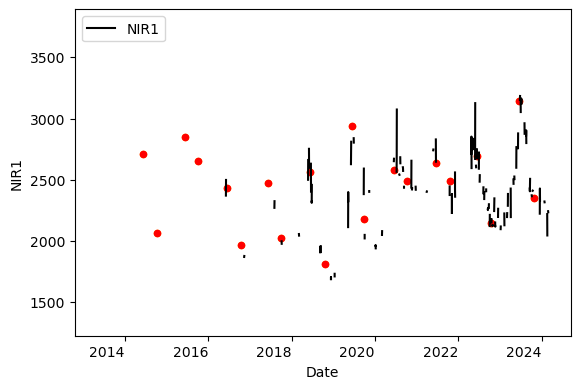

In [19]:
ID = '15E_P1'
var = 'NIR1'
ax1 = df_out_raw[(df_out_raw['Id'] == ID)].plot(x='Date', y=var, c='black')
df_out[(df_out['Id'] == ID)].plot.scatter(x='Date', y=var, c='orange', ax=ax1)
df_out[(df_out['Id'] == ID)].plot.scatter(x='Date', y=var, c='red', ax=ax1)

#### Manually merge HLS and LMF datasets

In [9]:
df_out_old = pd.read_csv(re.sub('.csv', '_old.csv', outPATH), parse_dates=['Date'])

In [14]:
df_out_manual = pd.concat([df_out[df_out['Year'] < lmf_yr_max], 
                           df_out_old[df_out_old['Year'] >= lmf_yr_max]])


In [15]:
df_out_manual['Year'].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [16]:
df_out_manual.to_csv(re.sub('.csv', '_manual_combine.csv', outPATH), index=False)

### OTHER TESTING (TEMP)

In [17]:
yr = 2015
# get subset of vor data for year
gdf_yr = gdf_vor[gdf_vor['Year'] == yr]
# set the bounding box for fetching data
bbox_yr = np.array(gdf_yr.total_bounds) # the entire subset dataset 
lmfPATH_yr = glob(os.path.join(lmfDIR, 'CPER_' + str(yr) + '*.nc'))
lmf_ds = riox.open_rasterio(lmfPATH_yr[0], 
              nodata=-9999, mask=True).sel(x=slice(bbox_yr[0], bbox_yr[2]),
                                           y=slice(bbox_yr[3], bbox_yr[1])).load()
lmf_ds = lmf_ds.chunk({'DOY': -1, 'y': 50, 'x': 50})

# create an xarray mask from the ground data
mask_info = gdf_vor.drop_duplicates(
    subset=['Id', 'Date'])[['Id', 'geometry']].reset_index(drop=True).reset_index().rename(
    columns={'index': 'id'})
mask_shp = [(row.geometry, row.id+1) for _, row in mask_info.iterrows()]
plot_mask = shp2mask(shp=mask_shp, 
                     transform=lmf_ds.rio.transform(), 
                     outshape=lmf_ds['BLUE'].shape[1:], 
                     xr_object=lmf_ds['BLUE'])
mask_dict = {row.id+1: row.Id for _, row in mask_info.iterrows()}
mask_dict[0] = 'UNK'
plot_mask = np.array([mask_dict[i] for i in plot_mask.values.flatten()]).reshape(plot_mask.shape)

# assign the plot id's to the xarray dataset
lmf_ds = lmf_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
lmf_ds = lmf_ds.set_coords('Plot')

# mask out areas outside ground plots
lmf_ds = lmf_ds.where(lmf_ds['Plot'] != 'UNK')

# lazy compute all vegetation indices
for vegidx in veg_dict:
    lmf_ds[vegidx] = veg_dict[vegidx](lmf_ds)

# convert to dataframe at plot scale
df_yr = lmf_ds[list(veg_dict.keys()) + band_list].groupby('Plot').mean('stacked_y_x').to_dataframe().reset_index()

df_yr['time'] = df_yr['DOY'].apply(lambda x: datetime(yr, 1, 1) + timedelta(days=x))
df_yr = df_yr.drop(columns=['DOY'])

start_date = df_yr['time'].min()
end_date = df_yr['time'].max()

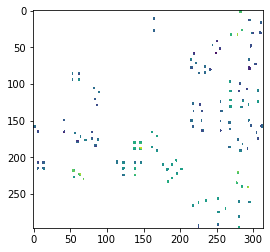

<AxesSubplot:>

In [18]:
from rasterio.plot import show
#(lmf_ds['SWIR1'].isel(DOY=278)/1000).values
show((lmf_ds['SWIR1'].isel(DOY=278)/1000).values)

In [41]:
df_yr[(df_yr['Plot'] == '25NW_P1') & (df_yr['time'] == '2013-10-06')]

,Plot,NDVI,DFI,NDTI,SATVI,NDII7,BAI_126,BAI_136,BAI_146,BAI_236,BAI_246,BAI_346,NIR1,SWIR1,SWIR2,spatial_ref,time
24367,25NW_P1,0.347822,11.6628,0.137122,0.218866,-0.030899,150.035533,159.821334,134.111776,170.917063,133.072568,125.956071,2387.172414,3347.344828,2540.793103,0,2013-10-06


In [19]:
test = lmf_ds['SWIR1'].sel(DOY=278).groupby('Plot').mean('stacked_y_x').to_dataframe().reset_index()
test[['25NW' in x for x in test['Plot']]]

,Plot,DOY,spatial_ref,SWIR1
66,25NW_P1,278.0,0,3515.000000
67,25NW_P2,278.0,0,3471.689655
68,25NW_P3,278.0,0,3443.482759
69,25NW_P4,278.0,0,3328.379310


In [51]:
# remove any dates where bands are nodata (-9999)
df_yr = df_yr[~(df_yr[band_list] < 0).any(axis=1)]

In [52]:
df_yr[(df_yr['Plot'] == ID)][var].min()

1007.56

<AxesSubplot:xlabel='Date', ylabel='NIR1'>

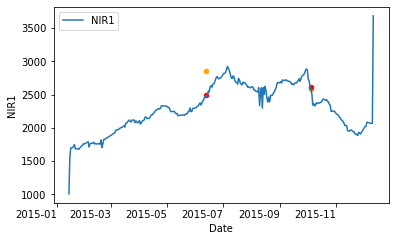

In [53]:
ID = '15E_P1'
var = 'NIR1'
ax1 = df_yr[(df_yr['Plot'] == ID)].plot(x='time', y=var)
df_out_old[(df_out_old['Id'] == ID) & 
           (df_out_old['Year'] == 2015)].plot.scatter(x='Date', y=var, c='orange', ax=ax1)
df_out[(df_out['Id'] == ID) & 
           (df_out['Year'] == 2015)].plot.scatter(x='Date', y=var, c='red', ax=ax1)

In [54]:
# remove all non-plot data
df_yr = df_yr[df_yr['Plot'] != 'UNK']

# rename columns to match VOR data
df_yr = df_yr.rename(columns={'time': 'Date',
                                'Plot': 'Id'})

In [55]:
# remove any dates where bands are nodata (-9999)
df_yr = df_yr[~(df_yr[band_list] < 0).any(axis=1)]

# get missing dates for gap-filling
dates_missing = [x for x in pd.date_range(start_date, end_date).date if x not in df_yr['Date'].dt.date.unique()]

# convert missing dates to a dataframe for combining with veg index data
df_missing = pd.DataFrame({
    'Id': list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df_yr['Id'].unique()])),
    'Date': list(chain.from_iterable(dates_missing for x in df_yr['Id'].unique()))})

# combine into one dataframe for gapfilling
df_yr_ts = pd.concat([df_yr, df_missing]).sort_values(['Id', 'Date'])

# smooth all vegetation indices to gapfill
for vegidx in veg_dict:
    df_yr_ts[vegidx + '_smooth'] = df_yr_ts.groupby('Id')[vegidx].transform(lambda x: double_savgol(x.values))
for band in band_list:
    df_yr_ts[band + '_smooth'] = df_yr_ts.groupby('Id')[band].transform(lambda x: double_savgol(x.values))

# convert date to datetime
df_yr_ts['Date'] = pd.to_datetime(df_yr_ts['Date'])

# rename smoothed columns and drop originals
df_yr_ts = df_yr_ts.drop(columns=list(veg_dict.keys()) + band_list)
col_rename_dict = {c: re.sub('_smooth', '', c) for c in df_yr_ts.columns if '_smooth' in c}
df_yr_ts = df_yr_ts.rename(columns=col_rename_dict)

/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/pandas/core/indexes/base.py:2237: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_unique
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/pandas/core/indexes/base.py:3809: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = self._engine.get_indexer(tgt_values)


In [58]:
df_yr[(df_yr['Id'] == ID)][var].min()

1007.56

<AxesSubplot:xlabel='Date', ylabel='SWIR1'>

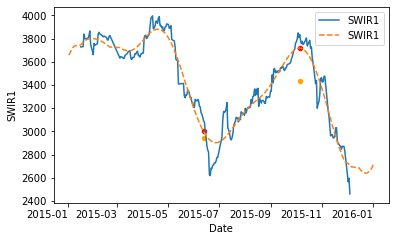

In [68]:
ID = 'CN_P2'
var = 'SWIR1'
ax1 = df_yr[(df_yr['Id'] == ID)].plot(x='Date', y=var)
df_yr_ts[(df_yr_ts['Id'] == ID)].plot(x='Date', y=var, ax=ax1, linestyle='dashed')
df_out_old[(df_out_old['Id'] == ID) & 
           (df_out_old['Year'] == 2015)].plot.scatter(x='Date', y=var, c='orange', ax=ax1)
df_out[(df_out['Id'] == ID) & 
           (df_out['Year'] == 2015)].plot.scatter(x='Date', y=var, c='red', ax=ax1)

In [59]:
dates_missing

[datetime.date(2013, 1, 2),
 datetime.date(2013, 1, 3),
 datetime.date(2013, 1, 4),
 datetime.date(2013, 2, 23),
 datetime.date(2013, 2, 24),
 datetime.date(2013, 2, 25),
 datetime.date(2013, 2, 26),
 datetime.date(2013, 10, 19),
 datetime.date(2013, 12, 7),
 datetime.date(2013, 12, 8),
 datetime.date(2013, 12, 9),
 datetime.date(2013, 12, 10),
 datetime.date(2013, 12, 11)]

<AxesSubplot:xlabel='Date'>

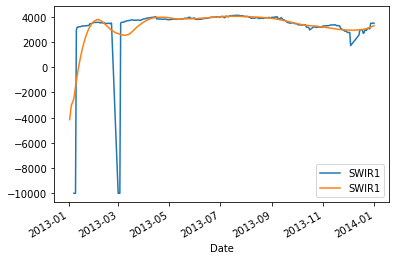

In [63]:
ax1 = df_yr[(df_yr['Id'] == '25NW_P1')].plot(x='Date', y='SWIR1')
df_yr_ts[(df_yr_ts['Id'] == '25NW_P1')].plot(x='Date', y='SWIR1', ax=ax1)

In [22]:
yr = 2014
from glob import glob
lmfPATH_yr = glob(os.path.join(lmfDIR, 'CPER_' + str(yr) + '*.nc'))
#lmfFILE_list = glob(os.path.join(lmfDIR_yr[0], '*.bin'))

In [7]:
bbox = gdf_vor.total_bounds

In [8]:
lmf_ds = riox.open_rasterio(lmfPATH_yr[0], 
                          nodata=-9999, mask=True).sel(x=slice(bbox[0], bbox[2]),
                                                       y=slice(bbox[3], bbox[1])).load()

Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


In [9]:
lmf_ds = lmf_ds.chunk({'DOY': -1, 'y': 50, 'x': 50})

In [10]:
# create an xarray mask from the ground data
mask_info = gdf_vor.drop_duplicates(
    subset=['Id', 'Date'])[['Id', 'geometry']].reset_index(drop=True).reset_index().rename(
    columns={'index': 'id'})
mask_shp = [(row.geometry, row.id+1) for _, row in mask_info.iterrows()]
plot_mask = shp2mask(shp=mask_shp, 
                     transform=lmf_ds.rio.transform(), 
                     outshape=lmf_ds['BLUE'].shape[1:], 
                     xr_object=lmf_ds['BLUE'])
mask_dict = {row.id+1: row.Id for _, row in mask_info.iterrows()}
mask_dict[0] = 'UNK'
plot_mask = np.array([mask_dict[i] for i in plot_mask.values.flatten()]).reshape(plot_mask.shape)

In [11]:
# assign the plot id's to the xarray dataset
lmf_ds = lmf_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
lmf_ds = lmf_ds.set_coords('Plot')

# mask out areas outside ground plots
lmf_ds = lmf_ds.where(lmf_ds['Plot'] != 'UNK')

# lazy compute all vegetation indices
for vegidx in veg_dict:
    lmf_ds[vegidx] = veg_dict[vegidx](lmf_ds)

# convert to dataframe at plot scale
df_yr = lmf_ds[list(veg_dict.keys()) + band_list].groupby('Plot').mean('stacked_y_x').to_dataframe().reset_index()

In [22]:
df_yr['time'] = df_yr['DOY'].apply(lambda x: datetime(yr, 1, 1) + timedelta(days=x))
df_yr = df_yr.drop(columns=['DOY'])

In [26]:
start_date = df_yr['time'].min()
end_date = df_yr['time'].max()

In [28]:
# remove all non-plot data
df_yr = df_yr[df_yr['Plot'] != 'UNK']

# rename columns to match VOR data
df_yr = df_yr.rename(columns={'time': 'Date',
                              'Plot': 'Id'})

# get missing dates for gap-filling
dates_missing = [x for x in pd.date_range(start_date, end_date).date if x not in df_yr['Date'].unique()]

# convert missing dates to a dataframe for combining with veg index data
df_missing = pd.DataFrame({
    'Id': list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df_yr['Id'].unique()])),
    'Date': list(chain.from_iterable(dates_missing for x in df_yr['Id'].unique()))})

# combine into one dataframe for gapfilling
df_yr_ts = pd.concat([df_yr, df_missing]).sort_values(['Id', 'Date'])

# smooth all vegetation indices to gapfill
for vegidx in veg_dict:
    df_yr_ts[vegidx + '_smooth'] = df_yr_ts.groupby('Id')[vegidx].transform(lambda x: double_savgol(x.values))
for band in band_list:
    df_yr_ts[band + '_smooth'] = df_yr_ts.groupby('Id')[band].transform(lambda x: double_savgol(x.values))

# convert date to datetime
df_yr_ts['Date'] = pd.to_datetime(df_yr_ts['Date'])

# rename smoothed columns and drop originals
df_yr_ts = df_yr_ts.drop(columns=list(veg_dict.keys()) + band_list)
col_rename_dict = {c: re.sub('_smooth', '', c) for c in df_yr_ts.columns if '_smooth' in c}
df_yr_ts = df_yr_ts.rename(columns=col_rename_dict)

<AxesSubplot:xlabel='DOY', ylabel='NDVI'>

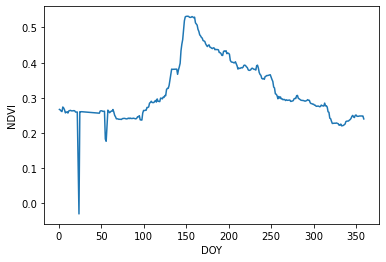

In [14]:
import seaborn as sns
sns.lineplot(x='DOY', y='NDVI', data=df_yr[df_yr['Plot'] == '10S_P1'])

<AxesSubplot:xlabel='Date', ylabel='DFI'>

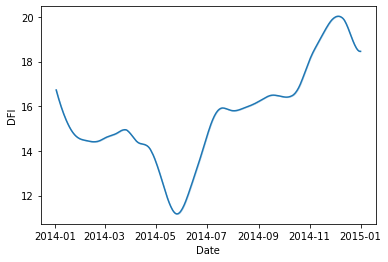

In [31]:
sns.lineplot(x='Date', y='DFI', data=df_yr_ts[df_yr_ts['Id'] == '10S_P1'])

In [9]:
import seaborn as sns

<AxesSubplot:xlabel='Date', ylabel='DFI'>

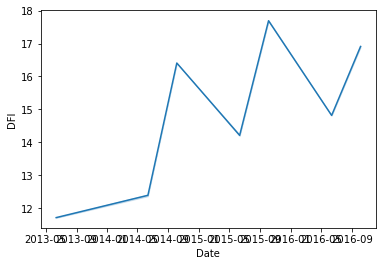

In [10]:
sns.lineplot(x='Date', y='DFI', data=df_out[df_out['Id'] == '10S_P1'])